#Model Training

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
from datetime import datetime
import matplotlib.pyplot as plt
from google.colab import drive
from IPython.display import Image
#from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import decode_predictions


def frames_extraction(video_path):
  '''
  This function will extract the required frames from a video after resizing and normalizing them.
  Args:
      video_path: The path of the video in the disk, whose frames are to be extracted.
  Returns:
      frames_list: A list containing the resized and normalized frames of the video.
  '''
  # Declare a list to store video frames.
  frames_list = []
  # Read the Video File using the VideoCapture object.
  video_reader = cv2.VideoCapture(video_path)
  # Get the total number of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  # Calculate the the interval after which frames will be added to the list.
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  # Iterate through the Video Frames.
  for frame_counter in range(SEQUENCE_LENGTH):

      # Set the current frame position of the video.
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

      # Reading the frame from the video. 
      success, frame = video_reader.read() 

      # Check if Video frame is not successfully read then break the loop
      if not success:
          break

      # Resize the Frame to fixed height and width.
      resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
      
      # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
      normalized_frame = resized_frame / 255
      
      # Append the normalized frame into the frames list
      frames_list.append(normalized_frame)
  
  # Release the VideoCapture object. 
  video_reader.release()

  # Return the frames list.
  return frames_list



def frames_extraction_augment(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    # Declare a list to store video frames.
    frames_list = []
    flipped_list = []
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        flipped_frame = cv2.flip(normalized_frame,3) # this line vertically flips the frame
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
        flipped_list.append(flipped_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list, flipped_list

def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for classname,file_names in videos.items():
      print(f'Extracting {classname} Frames')
      for video in file_names:       
        # Get the complete video path.
        video_file_path = f'drive/MyDrive/Colab Notebooks//FYP/train/{classname}/{video}'
        print(f'processing {video_file_path}')
        # Extract the frames of the video file.
        frames = frames_extraction(video_file_path)
        # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
        # So ignore the vides having frames less than the SEQUENCE_LENGTH.
        if len(frames) == SEQUENCE_LENGTH:
            # Append the data to their repective lists.
            features.append(frames)
            labels.append( classname)
            video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths


def create_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(videos), activation = 'softmax'))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(videos), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
# connecting to drive and setting seeds 
drive.mount('/content/drive')
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Mounted at /content/drive


In [ ]:
# Getting vidoes in dictionary to be iterated 
videos = {'not_overlock':os.listdir('drive/MyDrive/Colab Notebooks/FYP/train/not_overlock'),'overlock':os.listdir('drive/MyDrive/Colab Notebooks/FYP/train/overlock'),'smoke':os.listdir('drive/MyDrive/Colab Notebooks/FYP/train/smoke')}
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 250, 250
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()
# print(features)
# print(labels)

Extracting not_overlock Frames
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_660.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_670.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_680.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_690.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_700.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_710.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_720.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_730.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_740.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_750.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/overlock_760.mp4
processing drive/MyDrive/Colab Notebooks//FYP/train/not_overlock/ov

In [ ]:
# Saving the dataset in drive for later use 
np.save('drive/MyDrive/FYP/Features_Labels/featuresFactory', features)
np.save('drive/MyDrive/FYP/Features_Labels/labelsFactory', labels)
# np.save('drive/MyDrive/FYP/Features_Labels/paths', video_files_paths)

In [ ]:
# To load data from the saved np files
features = np.load('drive/MyDrive/FYP/Features_Labels/features5.npy')
labels = np.load('drive/MyDrive/FYP/Features_Labels/labels5.npy')
# video_files_paths = np.load('drive/MyDrive/FYP/Features_Labels/paths.npy')

In [ ]:
print(features.shape)
print(labels.shape)

(315, 10, 250, 250, 3)
(315,)


In [ ]:
print(features.shape, features.dtype)
print(labels.shape, labels.dtype)

(315, 10, 250, 250, 3) float64
(315,) <U12


In [ ]:
# Label encode the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.20, shuffle = True, random_state = seed_constant)

In [ ]:
np.save('drive/MyDrive/FYP/Features_Labels/X_train_filenames_300_10.npy', features_train)
np.save('drive/MyDrive/FYP/Features_Labels/y_train_300_10.npy', labels_train)
np.save('drive/MyDrive/FYP/Features_Labels/X_test_filenames_300_10.npy', features_test)
np.save('drive/MyDrive/FYP/Features_Labels/y_test_300_10.npy', labels_test)

In [ ]:
features_train = np.load('drive/MyDrive/FYP/Features_Labels/X_train_filenames_300_10.npy')
labels_train = np.load('drive/MyDrive/FYP/Features_Labels/y_train_300_10.npy')

In [ ]:
# class My_Custom_Generator(keras.utils.Sequence) :
  
#   def __init__(self, image_filenames, labels, batch_size) :
#     self.image_filenames = image_filenames
#     self.labels = labels
#     self.batch_size = batch_size
    
    
#   def __len__(self) :
#     return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
#   def __getitem__(self, idx) :
#     batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
#     batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
#     return np.array([
#             resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
#                for file_name in batch_x])/255.0, np.array(batch_y)

In [ ]:
model = create_model()
 # Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 250, 250, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 62, 62, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 62, 62, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 62, 62, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 15, 15, 32)   0

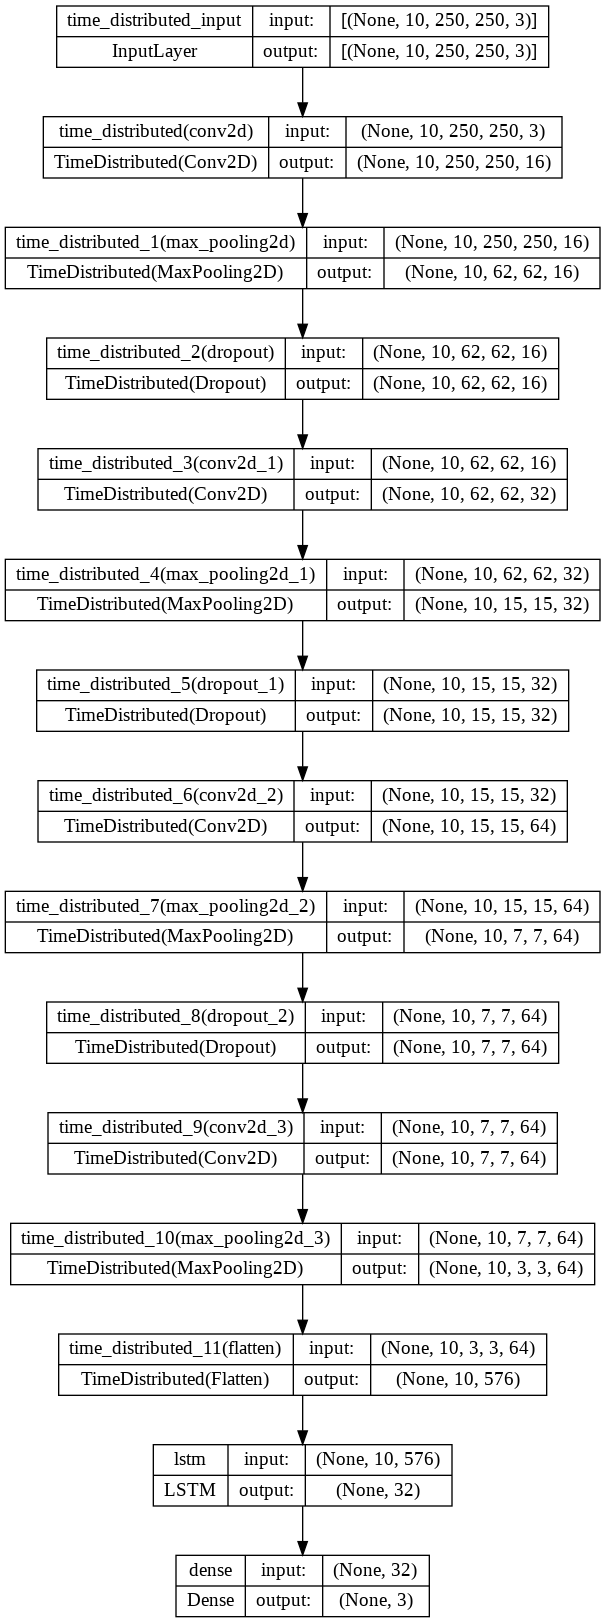

In [ ]:
# Plot the structure of the contructed model.
plot_model(model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
51/51 [==============================] - 36s 644ms/step - loss: 1.0299 - accuracy: 0.4826 - val_loss: 0.7159 - val_accuracy: 0.7647
Epoch 2/70
51/51 [==============================] - 31s 601ms/step - loss: 0.5657 - accuracy: 0.6915 - val_loss: 0.4930 - val_accuracy: 0.8235
Epoch 3/70
51/51 [==============================] - 31s 606ms/step - loss: 0.4313 - accuracy: 0.7960 - val_loss: 0.4370 - val_accuracy: 0.8235
Epoch 4/70
51/51 [==============================] - 30s 590ms/step - loss: 0.3619 - accuracy: 0.8657 - val_loss: 0.3334 - val_accuracy: 0.9020
Epoch 5/70
51/51 [==============================] - 31s 601ms/step - loss: 0.2919 - accuracy: 0.8856 - val_loss: 0.2372 - val_accuracy: 0.9216
Epoch 6/70
51/51 [==============================] - 30s 590ms/step - loss: 0.2600 - accuracy: 0.9104 - val_loss: 0.3387 - val_accuracy: 0.8235
Epoch 7/70
51/51 [==============================] - 30s 583ms/step - loss: 0.2868 - accuracy: 0.8806 - val_loss: 0.2925 - val_accuracy: 0.8627

In [ ]:
features_test = np.load('drive/MyDrive/FYP/Features_Labels/X_test_filenames_300_10.npy')
labels_test = np.load('drive/MyDrive/FYP/Features_Labels/y_test_300_10.npy')

In [ ]:
# To test the model 
model_evaluation_history = model.evaluate(features_test, labels_test)

2/2 [==============================] - 4s 1s/step - loss: 5.4560e-04 - accuracy: 1.0000


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'drive/MyDrive/factory_dataset{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}_250_10_sm.h5'

# Save the Model.
model.save(model_file_name)

In [ ]:
# loading model 
from tensorflow import keras
lrcn_model = keras.models.load_model("drive/MyDrive/factory_dataset2023_01_12__18_26_07___Loss_0.0005455954233184457___Accuracy_1.0_250_10_sm.h5")

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

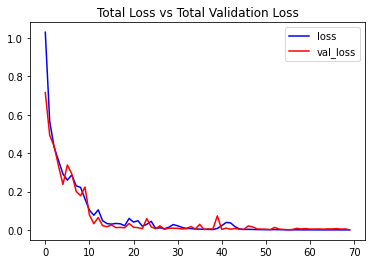

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

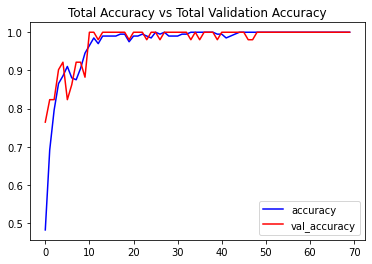

In [ ]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'drive/MyDrive/Colab Notebooks/test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=AsIcrWa1tdc', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
    a_shape = (1, 2)  # 3 rows and 4 columns
    predicted_labels_probabilities = np.empty(a_shape)
     
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break
        # Resize the Frame to fixed Dimensions.
 
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
            # print("erere")
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
            print(predicted_class_name)
        # Write predicted class name on top of the frame.
        
        cv2.putText(frame, predicted_class_name + np.array_str(predicted_labels_probabilities), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # + np.array_str(predicted_labels_probabilities)
 
        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
def predict_on_video_cam(SEQUENCE_LENGTH):
    vidcap = cv2.VideoCapture(0);
    count = 0
    success = True
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    while success:
        success,image = vidcap.read()
        if not success:
            break
        #cv2.imshow('frame', image)
        if count%30 == 0 :
            resized_frame = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            normalized_frame = resized_frame / 255
            frames_queue.append(normalized_frame)
            if len(frames_queue) == SEQUENCE_LENGTH:
                # Pass the normalized frames to the model and get the predicted probabilities.
                predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))[0]
                # Get the index of class with highest probability.
                predicted_label = np.argmax(predicted_labels_probabilities)
                # Get the class name using the retrieved index.
                predicted_class_name = CLASSES_LIST[predicted_label]
        count+=1
        print(predicted_class_name)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    vidcap.release()
    # Destroy all the windows
    cv2.destroyAllWindows()

In [ ]:
model = create_convlstm_model()
 # Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 10, 248, 248, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 124, 124, 4)  0         
 )                                                               
                                                                 
 time_distributed_12 (TimeDi  (None, 10, 124, 124, 4)  0         
 stributed)                                                      
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 122, 122, 8)   3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 10, 61, 61, 8)    0         
 3D)                                                             
                                                      

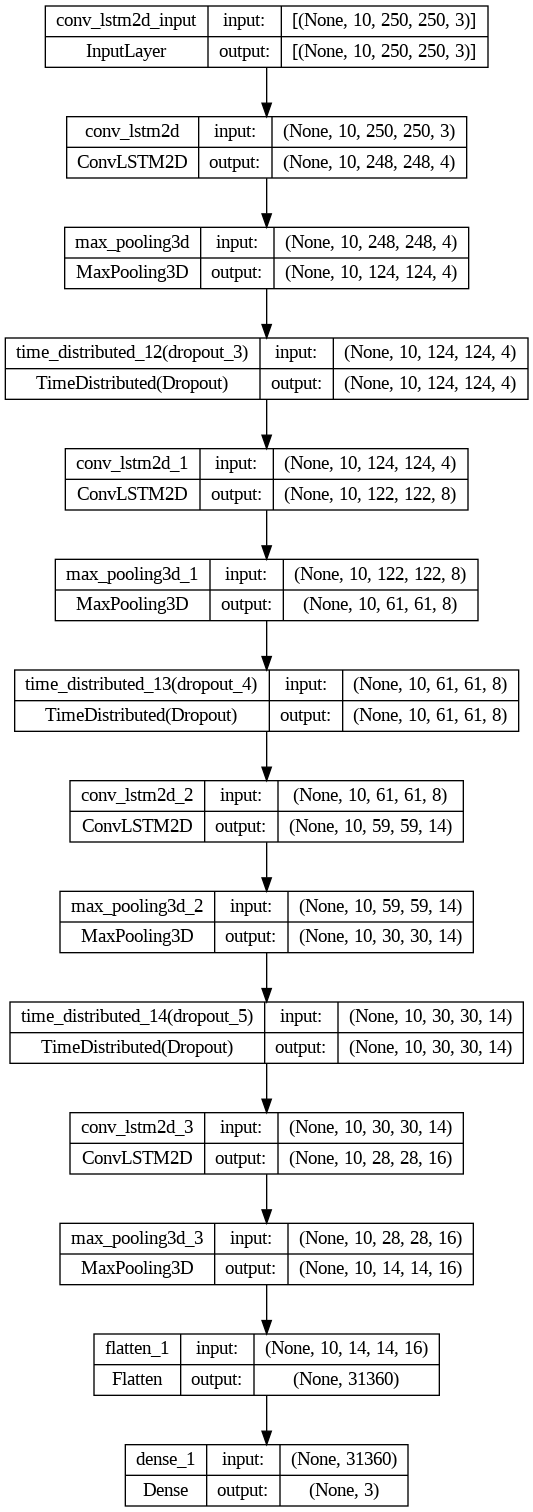

In [ ]:
# Plot the structure of the contructed model.
plot_model(model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 8, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/8
51/51 [==============================] - 477s 9s/step - loss: 0.7137 - accuracy: 0.7065 - val_loss: 0.2620 - val_accuracy: 0.8824
Epoch 2/8
51/51 [==============================] - 465s 9s/step - loss: 0.1432 - accuracy: 0.9453 - val_loss: 0.0713 - val_accuracy: 0.9804
Epoch 3/8
51/51 [==============================] - 463s 9s/step - loss: 0.0531 - accuracy: 0.9801 - val_loss: 0.1917 - val_accuracy: 0.9608
Epoch 4/8
51/51 [==============================] - 462s 9s/step - loss: 0.0515 - accuracy: 0.9851 - val_loss: 0.0631 - val_accuracy: 0.9804
Epoch 5/8
51/51 [==============================] - 462s 9s/step - loss: 0.1278 - accuracy: 0.9453 - val_loss: 0.0606 - val_accuracy: 0.9804
Epoch 6/8
51/51 [==============================] - 468s 9s/step - loss: 0.0285 - accuracy: 0.9851 - val_loss: 0.1054 - val_accuracy: 0.9804
Epoch 7/8
51/51 [==============================] - 463s 9s/step - loss: 0.0228 - accuracy: 0.9950 - val_loss: 0.0955 - val_accuracy: 0.9804
Epoch 8/8
51/51 [===

In [ ]:
# To test the model 
model_evaluation_history = model.evaluate(features_test, labels_test)

2/2 [==============================] - 34s 16s/step - loss: 0.0296 - accuracy: 0.9841


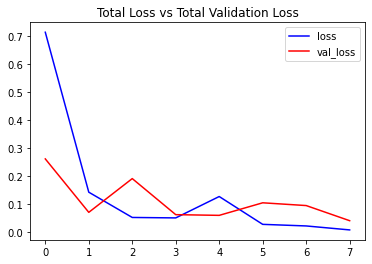

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

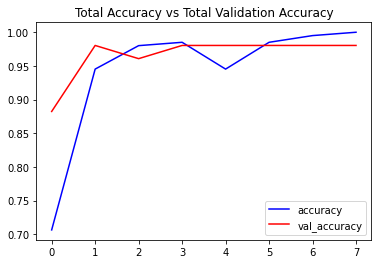

In [ ]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

2/2 [==============================] - 32s 16s/step


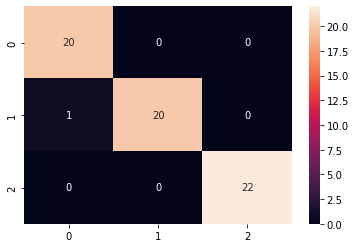

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(features_test)
cm = confusion_matrix(np.argmax(labels_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm,annot=True)

2/2 [==============================] - 7s 2s/step


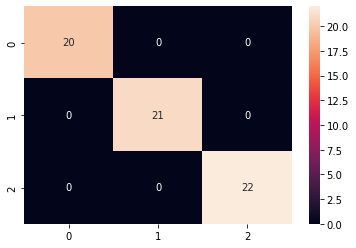

In [ ]:
y_pred = lrcn_model.predict(features_test)
cm = confusion_matrix(np.argmax(labels_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm,annot=True)